#### Mempersiapkan Library

In [1]:
import pandas as pd
import numpy as np
import re
import csv
import keras
import seaborn as sns
import pickle

from string import punctuation
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD


In [2]:
ls

 Volume in drive C is Windows
 Volume Serial Number is 01AA-1B3B

 Directory of c:\Users\Cupiz\Documents\GitHub\Sentiment-Analyst\Train

06/09/2023  03:43    <DIR>          .
06/09/2023  03:43    <DIR>          ..
06/09/2023  03:59            27.422 model_NN.ipynb
10/09/2023  15:51            84.461 modelCNN.ipynb
10/09/2023  22:50           103.884 modelLSTM.ipynb
10/09/2023  06:55            16.004 modelRegressi.ipynb
               4 File(s)        231.771 bytes
               2 Dir(s)  347.951.255.552 bytes free


#### Mempersiapkan Dataset

In [3]:
tsv_file_path = "../train_preprocess.tsv.txt"

data_text = []
label = []

with open(tsv_file_path, encoding='utf-8') as tsvfile:
    tsv_reader = csv.reader(tsvfile, delimiter='\t')
    for row in tsv_reader:
        data_text.append(row[0])
        label.append(row[1])

df = pd.DataFrame({'data_text': data_text, 'label': label})

In [4]:
train_data, test_data = train_test_split(df, test_size=0.2, random_state=0)
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=0)

In [5]:
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

(7040, 2)
(2200, 2)
(1760, 2)


In [6]:
print('Komposisi Label train_data:')
print(train_data['label'].value_counts())

print('Komposisi Label test_data:')
print(test_data['label'].value_counts())

print('Komposisi Label val_data:')
print(val_data['label'].value_counts())

Komposisi Label train_data:
positive    4134
negative    2185
neutral      721
Name: label, dtype: int64
Komposisi Label test_data:
positive    1272
negative     688
neutral      240
Name: label, dtype: int64
Komposisi Label val_data:
positive    1010
negative     563
neutral      187
Name: label, dtype: int64


#### Normalisasi Text

In [7]:
def lowercasing(paragraph):
    return paragraph.lower()

In [8]:
def menghilangkan_tandabaca(paragraph):
    new_paragraph = re.sub(fr'[{punctuation}]', r'', paragraph)
    return new_paragraph

In [9]:
def text_normalization(paragraph):
    paragraph = lowercasing(paragraph)
    paragraph = menghilangkan_tandabaca(paragraph)
    paragraph = re.sub(r"[ ]+",r' ',paragraph)
    return paragraph

In [10]:
train_data['data_text'] = train_data['data_text'].apply(lambda x: text_normalization(x))
test_data['data_text'] = test_data['data_text'].apply(lambda x: text_normalization(x))
val_data['data_text'] = val_data['data_text'].apply(lambda x: text_normalization(x))

#### Training Model

In [11]:
tokenizer = Tokenizer(oov_token='<UNK>')

In [12]:
tokenizer.fit_on_texts(train_data['data_text'])

In [13]:
train_data_tf = tokenizer.texts_to_sequences(train_data['data_text'])
test_data_tf = tokenizer.texts_to_sequences(test_data['data_text'])
val_data_tf = tokenizer.texts_to_sequences(val_data['data_text'])

In [14]:
train_data['data_text']

4057     indihome gangguan terus bayar nya saja mahal t...
7811     tempat pemandangan nya luar biasa dan pelayana...
5046     bagaimana kalau netizen pada patungan menyewa ...
7404                                           tidak sehat
8055     ulah sendiri kok gubernur yang disalahkan dasa...
                               ...                        
10959                  saya cemburu tapi tidak bisa apaapa
3997     bubarkan saja dpr rakyat tidak butuh diwakili ...
4118     steak di sini selalu membuat ketagihan menu ke...
5646                                      adit kayak tarik
10675    restoran sumoamg padang dago adalah palung pop...
Name: data_text, Length: 7040, dtype: object

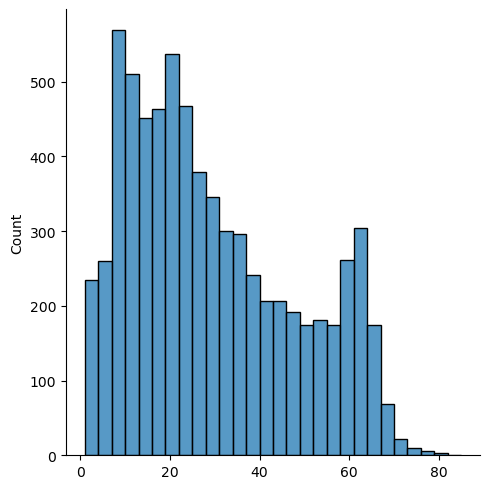

In [15]:
sns.displot([len(x) for x in train_data_tf])

In [16]:
max_len = int(np.quantile([len(x) for x in train_data_tf], 0.9))

In [17]:
max_len

59

In [18]:
train_padded = pad_sequences(sequences = train_data_tf, padding='post', maxlen=max_len)
test_padded = pad_sequences(sequences = test_data_tf, padding='post', maxlen=max_len)
val_padded = pad_sequences(sequences = val_data_tf, padding='post', maxlen=max_len)

In [19]:
print(train_padded.shape)
print(test_padded.shape)
print(val_padded.shape)

(7040, 59)
(2200, 59)
(1760, 59)


In [20]:
onehot = OneHotEncoder()

In [21]:
onehot.fit_transform(train_data[['label']])

<7040x3 sparse matrix of type '<class 'numpy.float64'>'
	with 7040 stored elements in Compressed Sparse Row format>

In [22]:
train_labels = onehot.fit_transform(train_data[['label']]).toarray()

#### Model Testing and Evaluation

In [23]:
model = Sequential()

In [24]:
max_features = len(tokenizer.index_word)
batch_size=16
output_dim = 64
input_len = max_len

In [25]:
model = keras.Sequential()
model.add(layers.Embedding(input_dim=len(tokenizer.index_word)+1,
                           output_dim=output_dim,
                           input_length=input_len))
model.add(layers.LSTM(128, dropout=0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(3, activation='softmax'))

In [26]:
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])

In [27]:
maximum_index_training = int(np.floor(train_padded.shape[0]/batch_size)*batch_size)
train = model.fit(x=train_padded[:maximum_index_training], 
          y=train_labels[:maximum_index_training],
          batch_size=batch_size, 
          epochs=20, 
          shuffle=False)

Epoch 1/20
440/440 [==============================] - 21s 44ms/step - loss: 0.7543 - accuracy: 0.6946
Epoch 2/20
440/440 [==============================] - 20s 44ms/step - loss: 0.7848 - accuracy: 0.6324
Epoch 3/20
440/440 [==============================] - 20s 45ms/step - loss: 0.7891 - accuracy: 0.6378
Epoch 4/20
440/440 [==============================] - 20s 45ms/step - loss: 0.5877 - accuracy: 0.7780
Epoch 5/20
440/440 [==============================] - 20s 45ms/step - loss: 0.5054 - accuracy: 0.8111
Epoch 6/20
440/440 [==============================] - 20s 45ms/step - loss: 0.3810 - accuracy: 0.8567
Epoch 7/20
440/440 [==============================] - 20s 45ms/step - loss: 0.2746 - accuracy: 0.9038
Epoch 8/20
440/440 [==============================] - 20s 45ms/step - loss: 0.1960 - accuracy: 0.9322
Epoch 9/20
440/440 [==============================] - 20s 45ms/step - loss: 0.1349 - accuracy: 0.9527
Epoch 10/20
440/440 [==============================] - 20s 45ms/step - loss: 0.100

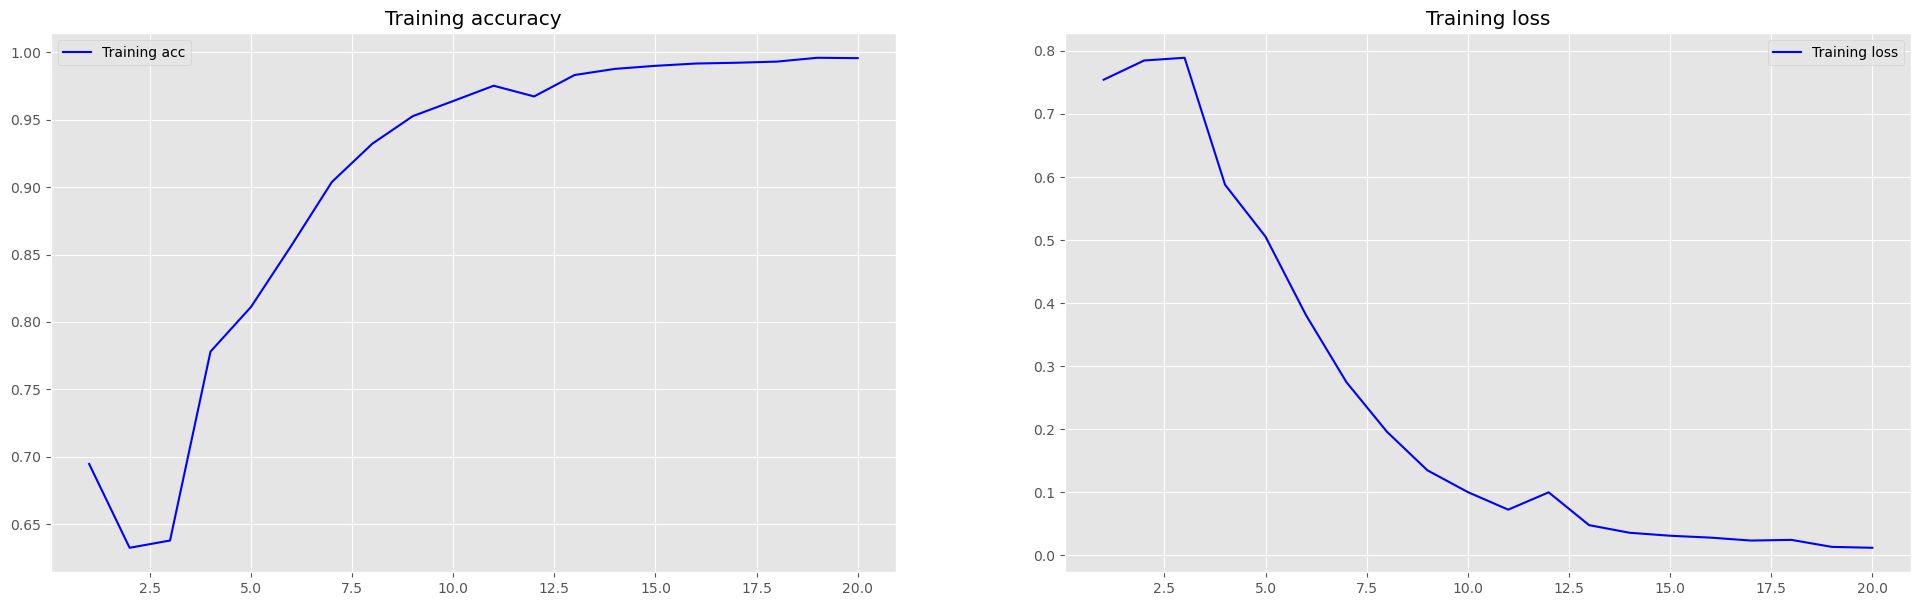

In [28]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_train(train):
    acc = train.history['accuracy']
    loss = train.history['loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(24, 7))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.title('Training accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.title('Training loss')
    plt.legend()

%matplotlib inline
plot_train(train)

In [29]:
y_pred = model.predict(val_padded,batch_size=1)

1760/1760 [==============================] - 7s 4ms/step


In [30]:
y_pred = onehot.inverse_transform(y_pred).reshape(-1)

In [31]:
pred = accuracy_score(y_pred=y_pred, y_true=val_data['label'])
print(pred)
print('{:.0%}'.format(pred))

0.8051136363636363
81%


In [33]:
print(classification_report(y_pred=y_pred, y_true=val_data['label']))

              precision    recall  f1-score   support

    negative       0.75      0.80      0.77       563
     neutral       0.73      0.44      0.55       187
    positive       0.84      0.88      0.86      1010

    accuracy                           0.81      1760
   macro avg       0.78      0.70      0.73      1760
weighted avg       0.80      0.81      0.80      1760



In [34]:
pickle.dump(model, open('../Model/model_LSTM.h5','wb'))

In [ ]:
pickle.dump(model, open('../Model/model_LSTM.h5','wb'))